### Μέλη Ομάδας:
* Ον/μο1: ΑΘανασίου Ιωάννης
* Αρ. Μητρώου 1: 03117041


# Τεχνητή Νοημοσύνη: Εργαστηριακή Άσκηση 3 
Στην άσκηση αυτή θα υλοποιηθούν διάφοροι (σχετικά απλοί) αλγόριθμοι μηχανικής μάθησης για την αυτόματη αναγνώριση μεταξύ 3 μουσικών είδών απο τα δεδομένα που προσφέρει η υπηρεσία Spotify. Συγκεκριμένα, θα δίνονται δύο σύνολα δεδομένων $$Ζ_{train}=\{(x_1,y_1),\dots,(x_n,y_n)\}$$ $$Z_{test} = \{(x_j,y_j),\dots{,(x_k,y_k)}\}$$ όπου κάθε $x_i\in{\mathbb{R}^p}$ είναι ένα διάνυσμα με τα μουσικά χαρακτηριστικά κάθε κομματιού (όπως dancability, acousticness κ.α.) και $y_i$ είναι το είδος του κομματιού - ένας ακέραιος στο $[0,2]$. Σε κάθε περίπτωση καλείστε να σχεδιάσετε έναν ταξινομητή, δηλαδή μια απεικόνιση $$f:\mathbb{R}^p\rightarrow{[0,2]}$$

# 1ο Μέρος: Αξιολόγηση




Στο πρώτο μέρος της άσκησης θα υλοποιηθούν συναρτήσεις που θα χρησιμοποιηθούν για την αξιολόγηση των ταξινομητών που θα χρησιμοποιηθούν στα επόμενα μέρη.

Παρακάτω σας δίνεται η κλάση Evaluate, η οποία υπολογίζει διάφορες μετρικές με τη μέθοδο get_metrics, εντοπίζει αντικείμενα που ταξινομήθηκαν λάθος και τα εμφανίζει (μέθοδος get_sample_of_wrong), και υπολογίζει τον πίνακα σύγχυσης (confusion matrix) όπου οπτικοποιούνται ανά κατηγορία οι προβλέψεις του ταξινομητή.

Για το μέρος αυτό καλείστε να υλοποιήσετε στη μέθοδο my_accuracy τη μετρική accuracy, η οποία ορίζεται ως:
$$accuracy = \frac{\#σωστών\_προβλέψεων}{\#δεδομένων}$$

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from matplotlib import pyplot as plt
import numpy as np
import random

class Evaluate:
    def __init__(self, y_true, y_pred):
        self.y_true = y_true
        self.y_pred = y_pred

    def my_accuracy(self):
      y_true = self.y_true
      y_pred = self.y_pred
      
      length = len(y_true)
      if length!=len(y_pred):
          raise Exception("The two vectors must have the same size.")

      comparisons = [y_true[i]==y_pred[i] for i in range(length)]
      correct = comparisons.count(True)
      acc = correct / length
      return acc

    def get_metrics(self):
        precision = precision_score(self.y_true, self.y_pred, average = "macro")
        recall = recall_score(self.y_true, self.y_pred, average = "macro")
        f1 = f1_score(self.y_true, self.y_pred, average = "macro")
        results = {"precision": precision, "recall": recall, "f1": f1, "accuracy": self.my_accuracy()}
        return results   
    
    def confusion_matrix(self):
        cm = confusion_matrix(self.y_true, self.y_pred)
        return cm 

    def get_evaluation_report(self):
        metrics = self.get_metrics()
        for m in metrics:
            print(m + ': ' + str(metrics[m]))
        cm = self.confusion_matrix()
        print("Confusion matrix: ")
        print(cm)

Παράδειγμα χρήσης της κλάσης. Κανονικά στο x θα υπάρχουν τα δεδομένα από το dataset

In [ ]:
y_true = [1, 0, 1, 0, 0, 1, 1, 0]
y_pred = [1, 0, 1, 0, 1, 1, 0, 0]

eval = Evaluate(y_true, y_pred)
eval.get_evaluation_report()

precision: 0.75
recall: 0.75
f1: 0.75
accuracy: 0.75
Confusion matrix: 
[[3 1]
 [1 3]]


# Dataset


To dataset που σας δίνεται περιέχει πληθώρα μουσικών κομματιών για τα οποία έχουν καταγραφεί διάφορα χαρακτηριστικά τους, όπως επίσης και το μουσικό είδος στο οποίο ανήκουν. Στη συγκεκριμένη άσκηση θα δουλέψουμε με ένα υποσύνολο (αριθμητικών) χαρακτηριστικών, τα οποία συνεισφέρουν στον καθορισμό της μουσικής κατηγορίας κάθε κομματιού.  

Τα χαρακτηριστικά τα οποία θα μελετήσουμε στην παρούσα άσκηση είναι τα "acousticness", "danceability", "energy", "instrumentalness", "liveness", "speechiness", ενώ οι κατηγορίες στις οποίες καλούμαστε να ταξινομήσουμε τα μουσικά κομμάτια είναι οι "Electronic", "Rock", και "Rap".

In [ ]:
# Σύνδεση του Google Colab με το Google Drive

from google.colab import drive
drive.mount('/content/drive')

Θα χρησιμοποιήσουμε τα DataFrames της βιβλιοθήκης pandas για να χειριστούμε τα δεδομένα μας. Μπορείτε να βρείτε περισσότερες πληροφορίες για τα pandas DataFrames στο αντίστοιχο [documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html).

In [ ]:
import pandas as pd
from tqdm.notebook import tqdm 

In [ ]:
# read data in the form of pandas DataFrame
data = pd.read_csv("music_df_processed.csv")

# print the first 5 values of the DataFrame using .head() command
data.head()

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.002,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic


In [ ]:
# What can we see here?
data.describe()

,instance_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,45020.000000,45020.000000,45020.000000,45020.000000,4.502000e+04,45020.000000,45020.000000,45020.000000,45020.000000,45020.000000,45020.000000,45020.000000
mean,55884.691892,44.263327,0.306596,0.558532,2.211695e+05,0.599553,0.181843,0.193951,-9.137016,0.093783,119.952961,0.456394
std,20728.197040,15.553972,0.341391,0.178858,1.276884e+05,0.264510,0.325847,0.161715,6.156400,0.101469,30.641701,0.247161
min,20002.000000,0.000000,0.000000,0.059600,-1.000000e+00,0.000792,0.000000,0.009670,-47.046000,0.022300,34.347000,0.000000
25%,38000.750000,34.000000,0.020100,0.442000,1.747230e+05,0.432000,0.000000,0.096900,-10.860000,0.036100,94.941500,0.257000
50%,55857.500000,45.000000,0.145000,0.568000,2.194385e+05,0.642000,0.000159,0.126000,-7.284000,0.048900,119.879000,0.448000
75%,73856.500000,56.000000,0.551000,0.687000,2.686400e+05,0.815250,0.154000,0.244000,-5.177000,0.098800,140.471250,0.648000
max,91759.000000,99.000000,0.996000,0.986000,4.497994e+06,0.999000,0.996000,1.000000,3.744000,0.942000,220.276000,0.992000


## Επιλογή χαρακτηριστικών x και στόχων y.  

Για λόγους απλότητας επιλέγουμε τα χαρακτηριστικά (inputs) και τις κατηγορίες-στόχους (genres). Καλείστε να διαχωρίσετε τα δεδομένα σε train/test set. Ας θεωρήσουμε το διαχωρισμό 30% - test set, 70% - train set.

In [ ]:
# χαρακτηριστικά
inputs = ["acousticness", "danceability", "energy", "instrumentalness", "liveness", "speechiness"]

# κατηγορίες-στόχοι
output = "music_genre"
genres = ["Electronic", "Rock", "Rap"]

# φιλτράρουμε το DataFrame ώστε να διατηρήσουμε μόνο τις 3 κατηγορίες που μας ενδιαφέρουν.
data = data[data[output].isin(genres)]

# dictionary to map genre to label id 
genres_to_id = {genre: i for i, genre in enumerate(genres)}

# εδώ πρέπει να διαχωρίσετε τα δεδομένα σε train (70% των δεδομένων)/test set (30% των δεδομένων)
# ονομάστε τις μεταβλητές ως εξής:
# τα χαρακτηριστικά του train set: x_train
# τις κατηγορίες-στόχους του train set: y_train
# τα χαρακτηριστικά του test set: x_test
# τις κατηγορίες-στόχους του test set: y_test
x_test, y_test, x_train, y_train = [], [], [], []


# keep the selected columns
columns_names = inputs + [output]
df = data[columns_names]
df[output] = df[output].apply(lambda genre: genres_to_id[genre])

# train-test-split
def my_train_test_split(df, train_percentage):
  df = df.sample(frac=1).reset_index(drop=True)

  rows = df.shape[0]
  train_limit = round(train_percentage*rows)

  x_train = df[inputs][:train_limit].values
  y_train = df[output][:train_limit].values

  x_test = df[inputs][train_limit:].values
  y_test = df[output][train_limit:].values

  return x_test, y_test, x_train, y_train

x_test, y_test, x_train, y_train = my_train_test_split(df, 0.7)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
y_train

array([2, 2, 0, ..., 0, 2, 2])

## Μορφή των δεδομένων  

Βεβαιωθείτε ότι τα δεδομένα σας έχουν τη σωστή μορφή εκτυπώνοντας τον αριθμό γραμμών και στηλών για τα x_test, y_test, x_train, y_train.

In [ ]:
# Shape of x_test, y_test, x_train, y_train

print("X-Y train shape:" , x_train.shape, y_train.shape)
print("X-Y test shape: " , x_test.shape, y_test.shape)

X-Y train shape: (9472, 6) (9472,)
X-Y test shape:  (4059, 6) (4059,)


Αναφορικά με τις τιμές των χαρακτηριστικών, είναι σημαντικό να γνωρίζουμε το εύρος τους, δηλαδή τη μέγιστη και την ελάχιστη τιμή που λαμβάνει το κάθε χαρακτηριστικό. Εξερευνήστε το εύρος του κάθε χαρακτηριστικού στα train και test set. 

In [ ]:
# Range of x_train, x_test columns
from tabulate import tabulate

##################
## Your code below
arr = []
for feature in inputs:
  min = df[feature].min()
  max = df[feature].max()
  diff = max-min
  row = [feature, min, max, diff]
  arr.append(row)

print(tabulate(arr, headers=["Feature", "Min", "Max", "Range"], tablefmt="grid"))


## Your code above
##################

+------------------+----------+-------+----------+
| Feature          |      Min |   Max |    Range |
+==================+==========+=======+==========+
| acousticness     | 1.39e-06 | 0.994 | 0.993999 |
+------------------+----------+-------+----------+
| danceability     | 0.0645   | 0.977 | 0.9125   |
+------------------+----------+-------+----------+
| energy           | 0.00259  | 0.999 | 0.99641  |
+------------------+----------+-------+----------+
| instrumentalness | 0        | 0.986 | 0.986    |
+------------------+----------+-------+----------+
| liveness         | 0.0173   | 0.991 | 0.9737   |
+------------------+----------+-------+----------+
| speechiness      | 0.0224   | 0.922 | 0.8996   |
+------------------+----------+-------+----------+


- Έχουν τα χαρακτηριστικά μας περίπου το ίδιο εύρος;
  * Ναι, παρατηρώ ότι το εύρος όλων των χαρακτηριστικών κυμαίνεται μεταξύ του 0.89 και του 1.
- Σε πολλές εφαρμογές είναι σημαντικό τα χαρακτηριστικά να βρίσκονται στο εύρος [0, 1]. Ισχύει αυτό στην περίπτωσή μας; 
  * Ναι, όπως φαίνεται από τις min και max τιμές τους.

# 2o Μέρος: Υλοποίηση KNN


Στο δεύτερο μέρος της άσκησης θα υλοποιήσετε τον αλγόριθμο KNN για ταξινόμηση. Υπενθυμίζεται από τις διαφάνειες το πλάνο σχεδιασμού για τον ταξινομητή k κοντινότερων γειτόνων:
- Αποθηκεύουμε όλα τα δεδομένα ($Z_{train}$) στη μνήμη
  - Τα δεδομένα μπορούν αποθηκευτούν σε έναν πίνακα $n\times{p}$ με χρήση του numpy
- Συγκρίνουμε την είσοδο με τα δεδομένα και βρίσκουμε τα k κοντινότερα ($k<n$) με βάση κάποια απόσταση.
  - Όταν μας δίνεται ένα "φρέσκο" δείγμα ως διάνυσμα από χαρακτηριστικά $x_i$ χρειαζόμαστε μια συνάρτηση που να υπολογίζει την απόσταση $d(x_i,x_j)$, όπου $x_j$ είναι το διάνυσμα που αντιστοιχεί στα χαρακτηριστικά ενός δείγματος από τα δεδομένα εκπαίδευσης. Θα πειραματιστείτε με την ευκλείδια απόσταση και την απόσταση συνημιτόνου. Στη συνέχεια ταξινομούνται τα δεδομένα εκπαίδευσης ως προς την απόστασή τους από το $x_i$ και επιλέγονται τα $k$ κοντινότερα
- Δίνουμε στην έξοδο την κλάση στην οποία ανήκει η πλειοψηφία των k κοντινότερων δεδομένων.

Αφού κατασκευαστεί ο ταξινομητής θα αξιολογήσετε την επίδοσή του στα 100 πρώτα δείγματα του $Z_{test}$ για κάποιες τιμές του k που θα επιλέξετε εσείς, ξεκινώντας από $k=1$.

Στην πράξη πολύ σπάνια θα χρειαστεί να υλοποιήσετε έναν αλγόριθμο μηχανικής μάθησης από το μηδέν, αφού υπάρχουν έτοιμες υλοποιήσεις, π.χ. σε πακέτα της python, οι οποίες είναι βελτιστοποιημένες και εύχρηστες. Το τελευταίο ζητούμενο  στο 2ο μέρος είναι να επαναλάβετε το παραπάνω πείραμα με την έτοιμη υλοποίηση του KNN που παρέχει η βιβλιοθήκη sklearn. Καλείστε να συγκρίνετε τα αποτελέσματα και τους χρόνους εκτέλεσης.

 Σας δίνεται η κλάση KNN η οποία αρχικοποιείται με ένα σύνολο από δεδομένα x, ετικέτες y και το k για τον αλγόριθμο. Καλείστε να συμπληρώσετε τον κώδικα που λείπει στις μεθόδους distance, get_knn, και classify.

Η απόσταση συνημιτόνου μεταξύ δύο διανυσμάτων u,v ορίζεται ως: $$d(u,v)= 1 - \frac{u\cdot{v}}{||u||_2||v||_2}$$

In [ ]:
from numpy import linalg

class KNN:
    def __init__(self, x, y, k, distance = "euclidean"):
        self.x = x
        self.y = y
        self.k = k
        self.distance = distance
        
    ## Compute the distance between the two vectors (2 rows of the DataFrame)
    # hint: use np.linalg.norm for eucledian
    # hint: use equation given above for cosine
    def get_distance(self, row1, row2):
      dist = None
      if self.distance=='euclidean':
        # print("Difference between:")
        # print("row1:", row1)
        # print("row2:", row2)
        dist = np.linalg.norm(row1-row2)
        
      elif self.distance=='cosine':
        u2 = np.linalg.norm(row1, ord=2)
        v2 = np.linalg.norm(row2, ord=2)
        denominator = u2*v2
        enumerator = np.dot(row1, row2)
        dist = 1 - (enumerator/denominator)
      
      else:
        raise Exception("Distance method not specified.")

      return dist

    ## Given a DataFrame row as a vector, returns indexes of k nearest neighbors
    def get_knn(self, row):
      distances = list()
      x = self.x
      k = self.k
      
      ##################
      ## Your code below - populate the distances list
      # hint: you can use a for loop
      for x_row in x:
        d = self.get_distance(x_row, row)
        distances.append(d)

      ## Your code above
      ##################

      # Sort distances, and return the indexes of k first elements
      ans_indexes = np.argsort(distances)[:k]
      return ans_indexes

    ## Given a DataFrame row as a vector, classify it according to KNN
    # hint: we have a list of k labels and want to return the most common one
    def classify(self, row):
      y = self.y
      #print("k nearest of row: ", end=' ')
      #print(row, end=" -> ")
      neighbours = self.get_knn(row)
      # print(f"Out of all {self.x.shape[0]} neighbours")
      # print("Found neighbours:", end=' ')
      # print(neighbours)
      nn_labels = [y[i] for i in neighbours]
      ##################
      ## Your code below
      counts = np.bincount(nn_labels)
      prediction = np.argmax(counts)
      ## Your code above
      ###################
      return prediction


knn = KNN(x_train, y_train, k=5, distance='euclidean')

Τώρα που είναι έτοιμος ο ταξινομητής ας δούμε τι προβλέπει σε μεμονωμένα δείγματα.

## Αξιολόγηση του KNN

In [ ]:
preds = [knn.classify(x_test[i]) for i in range(100)]
labels = [y_test[i] for i in range(100)]
print("My predictions:")
print(preds)
print("Real labels:")
print(labels)

My predictions:
[2, 0, 1, 2, 0, 1, 2, 0, 0, 2, 1, 1, 0, 2, 1, 0, 0, 1, 1, 1, 0, 2, 1, 1, 2, 2, 1, 1, 0, 2, 0, 0, 1, 0, 1, 1, 2, 1, 2, 0, 0, 1, 0, 0, 2, 1, 1, 0, 0, 1, 2, 1, 2, 0, 1, 1, 1, 2, 1, 1, 2, 2, 1, 0, 1, 0, 0, 2, 2, 2, 0, 0, 0, 1, 0, 1, 1, 1, 2, 1, 1, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 1, 2, 0, 0, 2, 0, 1, 1, 2]
Real labels:
[2, 0, 1, 0, 0, 2, 0, 0, 0, 2, 2, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 2, 2, 0, 2, 2, 1, 2, 0, 0, 0, 0, 1, 0, 1, 2, 2, 0, 2, 0, 1, 0, 2, 0, 0, 1, 2, 2, 0, 1, 2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 0, 1, 0, 1, 2, 1, 2, 2, 1, 0, 1, 0, 1, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0, 2, 1, 1, 2, 0, 2, 2, 2, 0, 0, 1, 0, 2, 2]


In [ ]:
eval = Evaluate(labels, preds)
eval.get_evaluation_report()

precision: 0.6068854568854569
recall: 0.6024492234169654
f1: 0.5998774509803922
accuracy: 0.6
Confusion matrix: 
[[22  5  6]
 [ 9 19  3]
 [ 4 13 19]]


## Έτοιμος ΚΝΝ classifier

Όπως και με τους περισσότερους αλγορίθμους μηχανικής μάθησης, υπάρχουν έτοιμες βελτιστοποιημένες υλοποιήσεις. Παρακάτω δείχνουμε ένα παράδειγμα χρήσης του ταξινομητή ΚΝΝ που παρέχει η βιβλιοθήκη sklearn ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)).

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

k = 5
knc = KNeighborsClassifier(n_neighbors = k)
knc.fit(x_train, y_train)
y_pred = knc.predict(x_test[:100])

eval = Evaluate(y_test[:100], y_pred)
eval.get_evaluation_report()

precision: 0.6068854568854569
recall: 0.6024492234169654
f1: 0.5998774509803922
accuracy: 0.6
Confusion matrix: 
[[22  5  6]
 [ 9 19  3]
 [ 4 13 19]]


## Σύγκριση υλοποιήσεων

Στα παρακάτω κελιά πειραματιστείτε με τις δύο υλοποιήσεις (τη δική σας και την έτοιμη). Βεβαιωθείτε πως προκύπτουν τα ίδια αποτελέσματα για διάφορες τιμές του k (για ευκλείδια απόσταση) και μετρήστε τους χρόνους εκτέλεσης.

* Για τους χρόνους εκτέλεσης για k = 5 τρέχουμε τα 3 παρακάτω κελιά:

In [ ]:
%%time
knn = KNN(x_train, y_train, k = 5, distance = 'euclidean')
my_preds_5_euclidean = [knn.classify(x_test[i]) for i in range(100)]

CPU times: user 8.21 s, sys: 696 ms, total: 8.91 s
Wall time: 8.2 s


In [ ]:
%%time
knn = KNN(x_train, y_train, k = 5, distance = 'cosine')
my_preds_5_cosine = [knn.classify(x_test[i]) for i in range(100)]

CPU times: user 15.1 s, sys: 240 ms, total: 15.3 s
Wall time: 15.1 s


In [ ]:
%%time
knc = KNeighborsClassifier(n_neighbors = 5)
knc.fit(x_train, y_train)
y_pred_5 = knc.predict(x_test[:100])

CPU times: user 19.9 ms, sys: 0 ns, total: 19.9 ms
Wall time: 22.6 ms


In [95]:
print("--> My KNN with euclidean distance:")
eval1 = Evaluate(labels, my_preds_5_euclidean)
eval1.get_evaluation_report()
my_metrics_5_euclidean = eval1.get_metrics()

--> My KNN with euclidean distance:
precision: 0.6068854568854569
recall: 0.6024492234169654
f1: 0.5998774509803922
accuracy: 0.6
Confusion matrix: 
[[22  5  6]
 [ 9 19  3]
 [ 4 13 19]]


In [96]:
print("My KNN with cosine distance:")
eval2 = Evaluate(labels, my_preds_5_cosine)
eval2.get_evaluation_report()
my_metrics_5_cosine = eval2.get_metrics()

My KNN with cosine distance:
precision: 0.5994998314038439
recall: 0.598159009449332
f1: 0.5946629655205421
accuracy: 0.6
Confusion matrix: 
[[24  3  6]
 [12 15  4]
 [ 5 10 21]]


In [102]:
print("Scikit knn:")
eval3 = Evaluate(labels, y_pred_5)
eval3.get_evaluation_report()
scikit_knn_5_metrics = eval3.get_metrics()

Scikit knn:
precision: 0.6068854568854569
recall: 0.6024492234169654
f1: 0.5998774509803922
accuracy: 0.6
Confusion matrix: 
[[22  5  6]
 [ 9 19  3]
 [ 4 13 19]]


Για τους χρόνους εκτέλεσης για k = 50 τρέχουμε τα 3 παρακάτω κελιά:

In [ ]:
%%time
knn = KNN(x_train, y_train, k = 50, distance = 'euclidean')
my_preds_50_euclidean = [knn.classify(x_test[i]) for i in range(100)]

CPU times: user 8.28 s, sys: 595 ms, total: 8.88 s
Wall time: 8.2 s


In [ ]:
%%time
knn = KNN(x_train, y_train, k = 50, distance = 'cosine')
my_preds_50_cosine = [knn.classify(x_test[i]) for i in range(100)]

CPU times: user 15.1 s, sys: 194 ms, total: 15.3 s
Wall time: 15.2 s


In [ ]:
%%time
knc = KNeighborsClassifier(n_neighbors = 50)
knc.fit(x_train, y_train)
y_pred_50 = knc.predict(x_test[:100])

CPU times: user 21.7 ms, sys: 0 ns, total: 21.7 ms
Wall time: 24.3 ms


In [98]:
print("--> My KNN with euclidean distance:")
eval4 = Evaluate(labels, my_preds_50_euclidean)
eval4.get_evaluation_report()
my_metrics_50_euclidan = eval4.get_metrics()

--> My KNN with euclidean distance:
precision: 0.6805860805860805
recall: 0.6609916367980884
f1: 0.6645500119360229
accuracy: 0.66
Confusion matrix: 
[[22  5  6]
 [ 4 21  6]
 [ 0 13 23]]


In [99]:
print("My KNN with cosine distance:")
eval5 = Evaluate(labels, my_preds_50_cosine)
eval5.get_evaluation_report()
my_metrics_50_cosine = eval5.get_metrics()

My KNN with cosine distance:
precision: 0.6462547740438206
recall: 0.641631367437819
f1: 0.6412126140778893
accuracy: 0.64
Confusion matrix: 
[[21  5  7]
 [ 5 21  5]
 [ 3 11 22]]


In [101]:
print("Scikit knn:")
eval6 = Evaluate(labels, y_pred_50)
eval6.get_evaluation_report()
scikit_knn_50_metrics = eval6.get_metrics()

Scikit knn:
precision: 0.6805860805860805
recall: 0.6609916367980884
f1: 0.6645500119360229
accuracy: 0.66
Confusion matrix: 
[[22  5  6]
 [ 4 21  6]
 [ 0 13 23]]


* Ορίζω μια βοηθητική συνάρτηση για τις γραφικές παραστάσεις του σχεδιασμού που θα ακολουθήσει:

In [111]:
import matplotlib.pyplot as plt

def plot_metrics(names, values):

  fig, axs = plt.subplots(1, 4, figsize=(20, 3), sharey=True)
  precisions, recalls, f1s, accuracies = [], [], [], []
  for metrics in values:
    vals = list(metrics.values())
    precisions.append(vals[0])
    recalls.append(vals[1])
    f1s.append(vals[2])
    accuracies.append(vals[3])

  axs[0].plot(names, precisions)
  axs[0].set_title("Precision")
  axs[1].plot(names, recalls)
  axs[1].set_title("Recall")
  axs[2].plot(names, f1s)
  axs[2].set_title("F1")
  axs[3].plot(names, accuracies)
  axs[3].set_title("Accuracy")

## Σχολιασμός


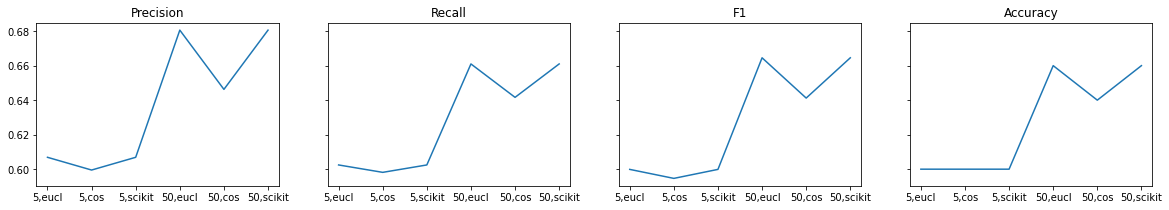

In [112]:
names=['5,eucl', '5,cos', '5,scikit', '50,eucl', '50,cos', '50,scikit' ]
values = [
  my_metrics_5_euclidean,
  my_metrics_5_cosine,
  scikit_knn_5_metrics,
  my_metrics_50_euclidan,
  my_metrics_50_cosine,
  scikit_knn_50_metrics,
]

plot_metrics(names, values)

  * Ο KNN του scikit εκπαιδεύεται πολύ γρηγορότερα από τους δικούς μου KNN classifiers.
  * Ο δικός μου classifier με χρήση ευκλείδιας απόστασης χρειάζεται λιγότερο χρόνο από εκείνο με την cosine απόσταση για να εκπαιδευτεί.
  * Όσον αφορά τις επιδόσεις τους, οπως φαίνεται και στην γραφική παράσταση, ο KNN του scikit και ο δικός μου classifier με ευκλείδια απόσταση κάνουν τις ίδιες προβλέψεις, ενώ ο δικός μου classifier με χρήση cosine απόστασης έχει χειρότερες επιδόσεις.
  * Η αύξηση του k από 5 σε 50:
    * για τον δικό μου KNN που χρησιμοποιεί ευκλείδια απόσταση και για τον classifier του scikit:
      * αυξάνει ελάχιστα τον χρόνο 
      * βελτιώνει τις μετρικές της επίδοσής τους
    * για τον δικό μου classifier που χρησιμοποεί cosine:
      * δεν φαίνεται να αυξάνει σχεδόν καθόλου τον χρόνο
      * βελτιώνει τις μετρικές 

# 3ο Μέρος: Naive Bayes

Στο τρίτο μέρος της άσκησης θα υλοποιήσετε τον αλγόριθμο Naive Bayes. Ας θυμηθούμε από τις διαφάνειες:

**Υποθέσεις:**
- Τα χαρακτηριστικά είναι boolean αντί για συνεχή, δηλαδή παίρνουν δύο τιμές 0 ή 1. Συνεπώς, χρειάζεται να τροποποιήσουμε τα χαρακτηριστικά του dataset μας.
  - Για το συγκεκριμένο πρόβλημα μπορούμε να 'σπάσουμε' τις τιμές κάθε χαρακτηριστικού σε N διαφορετικά bins. Για παράδειγμα, για ένα χαρακτηριστικό που οι τιμές του κυμαίνονται στο [0, 1], για Ν=5, θα έχουμε τα ακόλουθα bins: [0, 0.2), [0.2, 0.4), [0.4, 0.6), [0.6, 0.8), [0.8, 1]. (Γι αυτό το λόγο στα προηγούμενα βήματα αναφέραμε ότι είναι σημαντικό να έχουμε τα χαρακτηριστικά μας στο [0, 1]!)
  
- Η πιθανότητα ένα στοιχείο με χαρακτηριστικά x να ανήκει στην κλάση i δίνεται από τον τύπο:
$$p(i|x)=\frac{p(i)\cdot{\prod_{k=1}^p}p(x^{(k)}|i)}{\sum_{j=1}^pp(x^{(k)}|j)}$$
- Για να ταξινομήσουμε ένα διάνυσμα χαρακτηριστικών x σε μια κλάση i επιλέγουμε την κλάση που μεγιστοποιεί την παραπάνω πιθανότητα
  - Μπορούμε για τη σύγκριση να αγνοήσουμε τον παρονομαστή, αφού για όλες τις κλάσεις θα είναι ίδιος

In [ ]:
# κάνουμε κάθε μεταβλήτη του συνόλου εκπαίδευσης διακρίτη σε σε διαστήματα 

def discretize(x, num_of_classes = 5):  
    x_r = []
    for row in x_train:
        discrete = []
        for i, feature in enumerate(row):
            discrete_feature = [0] * num_of_classes
            for j, v in enumerate(np.linspace(0, 1, num_of_classes + 1)):
                if float(feature) < v:
                    break
            discrete_feature[j-1] = 1
            discrete += discrete_feature
        x_r.append(discrete)
    return np.array(x_r)

x_train_r = discretize(x_train)
x_test_r = discretize(x_test)

Παρακάτω σας δίνεται η κλάση NaiveBayes που υλοποιεί τον αλγόριθμο. Καλείστε αρχικά να υπολογίσετε την πιθανότητα $p(x^{(k)}|i)$ για διάνυσμα χαρακτηριστκών $x$ και κατηγορία $i$ στη μέθοδο compute_probabilities. Στη συνέχεια θα υπολογίσετε την πιθανότητα $p(i|x)$ στη μέθοδο predict.

In [ ]:
from operator import mul
from functools import reduce

class NaiveBayes:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        ## pC is a vector with the probability of each class
        self.pC = np.zeros((len(genres),))
        ## pxC is an array with all probabilities p(xi|C)
        self.pxC = np.zeros((x.shape[-1], len(genres)))
        ## Compute the probabilities
        self.compute_probabilities()

    def count_features_in_classes(self):
      # for each row [x1, x2, x3, x4, ..., xn, y]
      for row_index in range(self.x.shape[0]):
        label = self.y[row_index]
        features = self.x[row_index]
        # for each feature
        for feature_index in range(self.x.shape[1]):
          # increase the feature-label counter
          if features[feature_index]:
              self.pxC[feature_index][label] += 1

    def compute_probabilities(self):
        ## Compute p(C) for each class
        for label in self.y:
          self.pC[label] += 1
        self.pC = self.pC / self.y.shape[0]

        ## Compute p(xi|C) for each feature xi and class C
        # hint: you can use one or more for loops
        
        rows = self.x.shape[0]
        row_length = self.x.shape[1]

        self.count_features_in_classes()
        
        # how many samples belong to each label
        labels_count = np.bincount(self.y)
        #print(labels_count)
        #print(self.pxC)
        
        # for each feature
        c=0
        for feature_index in range(row_length):
          for label in range(len(genres)):
            #print(self.pxC[feature_index][label], labels_count[label])
            self.pxC[feature_index][label] /= labels_count[label]    
            c+=1
        

    def predict(self, x):
        ## ~Probability of x belonging to each class
        ## (not actucal probability since we ignore denominator)
        pcX = np.ones((len(genres),))
        xsize = self.x.shape[-1]
        for i in range(len(genres)):
          # hint: We have probabilities p({x_j=1}|i) in self.pxC
          # We also need p({x_j=0}|i) for computing p(x|i)
          #################
          ## Your code below
          
          product_list = [self.pxC[feature_index][i] for feature_index in range(xsize) if x[feature_index]]                
          product = 1
          for prod in product_list:
            if prod:
              product *= prod
          # print('mul by:', product)
          pcX[i] = self.pC[i] * product
          # print("Index:", i, "pcX[i]:", pcX[i])
        # print(pcX)
          ## Your code above
          ##################
        return np.argmax(pcX)

## Αξιολόγηση του Naive Bayes

In [ ]:
nb = NaiveBayes(x_train_r, y_train)

print(nb.pxC)

preds = [nb.predict(i) for i in x_test_r[:100]]
print("Preds: ", list(nb.predict(i) for i in x_test_r))
print("Labels:", list(y_test))
eval = Evaluate(y_test[:100], preds)
eval.get_evaluation_report()

[[0.79372197 0.67402966 0.68783401]
 [0.09769379 0.13568949 0.17510217]
 [0.0557335  0.07952035 0.08613644]
 [0.0342729  0.06689808 0.04118202]
 [0.01857783 0.04386242 0.00974536]
 [0.00640615 0.00757337 0.        ]
 [0.07367072 0.15083623 0.02577806]
 [0.33536195 0.50930893 0.21282616]
 [0.48110186 0.3152414  0.49889972]
 [0.10345932 0.01704008 0.26249607]
 [0.00480461 0.01704008 0.00220057]
 [0.0557335  0.08583149 0.05281358]
 [0.18161435 0.20006311 0.32819868]
 [0.31806534 0.33165036 0.43131091]
 [0.43978219 0.36541496 0.18547627]
 [0.50704676 0.91574629 0.98805407]
 [0.07751441 0.02619123 0.0056586 ]
 [0.08167841 0.0205112  0.0018862 ]
 [0.12107623 0.01798675 0.00220057]
 [0.21268418 0.01956453 0.00220057]
 [0.6623959  0.69485642 0.68154668]
 [0.22741832 0.23288104 0.22980195]
 [0.05893658 0.03944462 0.05469978]
 [0.03491352 0.02398233 0.02703552]
 [0.01633568 0.00883559 0.00691606]
 [0.86386931 0.98106658 0.57497642]
 [0.1111467  0.01767119 0.3599497 ]
 [0.02274183 0.00126223 0.05

## Έτοιμος Naive Bayes

Όπως με τους περισσότερους αλγορίθμους μηχανικής μάθησης, υπάρχουν έτοιμες βελτιστοποιημένες υλοποιήσεις για τον Naive Bayes. Παρακάτω ο Gaussian Naive Bayes από το Sklearn. Σε αντίθεση με τη δική μας υλοποίηση, ο συγκεκριμένος δουλεύει και με συνεχή δεδομένα, αφού πρώτα κάνει την υπόθεση πως κάθε χαρακτηριστικό ακολουθεί κανονική κατανομή ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)).

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
y_pred = gnb.fit(x_train, y_train).predict(x_test[:100])

eval = Evaluate(y_test[:100], y_pred)
eval.get_evaluation_report()

precision: 0.7148351648351648
recall: 0.679971760616922
f1: 0.6816856957207835
accuracy: 0.68
Confusion matrix: 
[[19  6  8]
 [ 2 23  6]
 [ 0 10 26]]


## Μελέτη επίδρασης του αριθμού των διακριτών διαστημάτων

* Παρατηρώ ότι όταν χρησιμοποιούμε 5 διαστήματα για να κάνουμε διακριτές τις μεταβλητές εισόδου, πετυχαίνουμε πολύ χαμηλή απόδοση σε σχέση με τον έτοιμο GNB του scikit-learn
* Γι αυτό το λόγο, δοκιμάζω να χρησιμοποιήσω περισσότερα διαστήματα (10):

In [ ]:
x_train_r2 = discretize(x_train, num_of_classes=10)
x_test_r2 = discretize(x_test, num_of_classes=10)

*  και εκπαιδεύω έναν νέο Naive Bayes πάνω τους:

In [ ]:
nb = NaiveBayes(x_train_r2, y_train)

preds = [nb.predict(i) for i in x_test_r2[:100]]
eval = Evaluate(y_test[:100], preds)
eval.get_metrics()

{'accuracy': 0.37,
 'f1': 0.36766201685556527,
 'precision': 0.3740787413602169,
 'recall': 0.37341153470185723}

* παρατηρώ μία μικρή βελτίωση των μετρικών, και επομένως δοκιμάζω ακόμα περισσότερες τιμές του αριθμού των διαστημάτων:

In [ ]:
def discretize_train_test(x_train, x_test, num_of_classes=5):
  print("--> Number of classes:", num_of_classes)
  x_train_r3 = discretize(x_train, num_of_classes)
  x_test_r3 = discretize(x_test, num_of_classes)
  nb = NaiveBayes(x_train_r3, y_train)
  preds = [nb.predict(i) for i in x_test_r3[:100]]
  eval = Evaluate(y_test[:100], preds)
  res = eval.get_metrics()
  print(res)
  return res

--> Number of classes: 5
{'precision': 0.3337316263632053, 'recall': 0.33862821766047574, 'f1': 0.3333881004703128, 'accuracy': 0.34}
--> Number of classes: 10
{'precision': 0.3740787413602169, 'recall': 0.37341153470185723, 'f1': 0.36766201685556527, 'accuracy': 0.37}
--> Number of classes: 15
{'precision': 0.35501687940712334, 'recall': 0.36013359400456174, 'f1': 0.35146441584797755, 'accuracy': 0.36}
--> Number of classes: 20
{'precision': 0.40935470354075004, 'recall': 0.42166286521125235, 'f1': 0.40546361818008236, 'accuracy': 0.42}
--> Number of classes: 25
{'precision': 0.4310485516115871, 'recall': 0.42035950906918645, 'f1': 0.4126819126819126, 'accuracy': 0.42}
--> Number of classes: 30
{'precision': 0.40864661654135337, 'recall': 0.42166286521125235, 'f1': 0.40558702926239754, 'accuracy': 0.42}
----------------PLOTTING-----------------


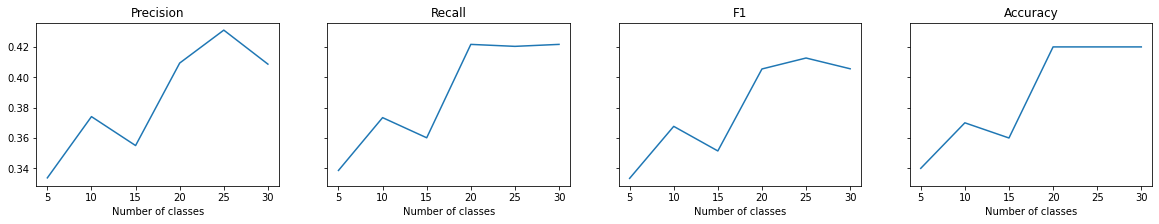

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(20, 3), sharey=True)
metrics = dict()
metrics['precision'] = dict()
metrics['recall'] = dict()
metrics['f1'] = dict()
metrics['accuracy'] = dict()

for num in range(5, 31, 5):
  metrics_ =  discretize_train_test(x_train, y_train, num_of_classes=num)
  prec, recall, f1, acc = metrics_.values()
  metrics['precision'][num] = prec
  metrics['recall'][num]    = recall
  metrics['f1'][num]        = f1
  metrics['accuracy'][num]  = acc

print("----------------PLOTTING-----------------")
axs[0].plot(list(metrics['precision'].keys()), list(metrics['precision'].values()))
axs[0].set_title('Precision')
axs[1].plot(list(metrics['recall'].keys()), list(metrics['recall'].values()))
axs[1].set_title('Recall')
axs[2].plot(list(metrics['f1'].keys()), list(metrics['f1'].values()))
axs[2].set_title('F1')
axs[3].plot(list(metrics['accuracy'].keys()), list(metrics['accuracy'].values()))
axs[3].set_title('Accuracy')

for ax in axs:
  ax.set_xlabel("Number of classes")


* Παρατηρώ, επομένως, ότι η αύξηση του αριθμού των κλάσεων μέχρι και τις 30, μπορεί να βελτιώσει τις μετρικές (από 34% σε 42% περίπου) 

## Σύγκριση υλοποιήσεων

Όμοια με πριν θα συγκρίνετε τα αποτελέσματα και τους χρόνους εκτέλεσης για τις δύο υλοποιήσεις. Σχολιάστε την επίδοση σε κάθε περίπτωση. Ποιες από τις παραδοχές που κάναμε δεν ισχύουν;

* Ο δικός μας classifier με 10 διαστήματα:




In [ ]:
%%time
nb = NaiveBayes(x_train_r,y_train)
my_preds_10 = [ nb.predict(i) for i in x_test_r[:100]]

CPU times: user 229 ms, sys: 1.72 ms, total: 231 ms
Wall time: 252 ms


In [ ]:
eval = Evaluate(y_test[:100], my_preds_10)
eval.get_evaluation_report()
my_metrics_10 = eval.get_metrics()

precision: 0.3337316263632053
recall: 0.33862821766047574
f1: 0.3333881004703128
accuracy: 0.34
Confusion matrix: 
[[ 7 16 10]
 [ 7 12 12]
 [11 10 15]]


* Ο δικός μας classifier με 30 διαστήματα:




In [ ]:
x_train_r30 = discretize(x_train, num_of_classes=30)
x_test_r30 = discretize(x_test, num_of_classes=30)

In [ ]:
%%time
nb = NaiveBayes(x_train_r30,y_train)
my_preds_30 = [ nb.predict(i) for i in x_test_r30[:100]]

CPU times: user 654 ms, sys: 3.19 ms, total: 657 ms
Wall time: 1.21 s


In [ ]:
eval = Evaluate(y_test[:100], my_preds_30)
eval.get_evaluation_report()
my_metrics_30 = eval.get_metrics()

precision: 0.40864661654135337
recall: 0.42166286521125235
f1: 0.40558702926239754
accuracy: 0.42
Confusion matrix: 
[[ 7 14 12]
 [ 4 18  9]
 [ 9 10 17]]


* O classifier του scikit-learn:

In [ ]:
%%time
gnb = GaussianNB()
gnb_preds = gnb.fit(x_train, y_train).predict(x_test[:100])

CPU times: user 6.83 ms, sys: 968 µs, total: 7.8 ms
Wall time: 40.4 ms


In [ ]:
eval = Evaluate(y_test[:100], gnb_preds)
eval.get_evaluation_report()
gnb_metrics = eval.get_metrics()

precision: 0.7148351648351648
recall: 0.679971760616922
f1: 0.6816856957207835
accuracy: 0.68
Confusion matrix: 
[[19  6  8]
 [ 2 23  6]
 [ 0 10 26]]


## Σχολιασμός



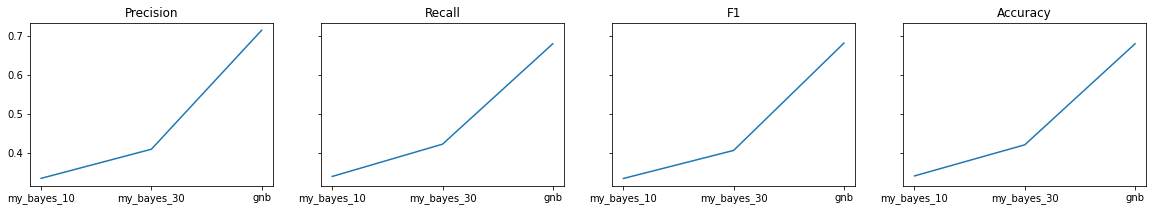

In [114]:
import matplotlib.pyplot as plt

names = ['my_bayes_10', 'my_bayes_30', 'gnb']
values = [my_metrics_10, my_metrics_30, gnb_metrics]

plot_metrics(names, values)

* Παρατηρώ ότι και πάλι ο classifier του scikit-learn χρειάζεται πολύ λιγότερο χρόνο από τον δικό μας classifier.
* Όσον αφορά τις μετρικές των επιδόσεών τους, ο classifier του scikit-learn παρουσιάζει σημαντικά καλύτερες επιδόσεις από τους δικό μας classifier.
  * Σίγουρα ατό οφείλεται σε μεγάλο βαθμό στον τρόπο με τον οποίο μετατρέψαμε την είσοδο σε διακριτή.
    * Αυτό επιβεβαιώνεται και από την βελτίωση στις μετρικές με την αύξηση του πλήθους των διαστημάτων.
  * Ίσως να οφείλεται και στο ότι στον Naive Bayes του scikit-learn θεωρείται ότι η P(xi|y) ακολουθεί η κανονική κατανομή.
    * Πιθανώς, η παραδοχή αυτή του Naive Bayes του scikit-learn να ταιριάζει καλύτερα στο dataset του συγκεκριμένου προβλήματος.

# 4ο Μέρος: Multi-Layer Perceptron 

Στο τέταρτο μέρος της άσκησης θα κατασκευάσετε ένα πολυεπίπεδο νευρωνικό δίκτυο. Ο ταξινομητής αυτός θα εκπαιδευτεί στο να ταξινομεί τα δείγματα των μουσικών κομματιών σε μια από τις 3 διαφορετικές κλάσεις που επιλέχθηκαν (Electronic, Rock, Rap). Αρχικά, θα υλοποιήσετε το μοντέλο αυτό χρησιμοποιώντας αποκλειστικά την βιβλιοθήκη numpy ενώ στην συνέχεια θα χρησιμοποιήσετε μια έτοιμη κλάση για την κατασκευή του ίδιου μοντέλου. 

Ας θυμηθούμε από τις διαφάνειες: 

Κάθε MLP αποτελείται από επίπεδα όπου το κάθε ένα από αυτά χωρίζεται στα παρακάτω μέρη: 

$$ z(x) = w^Τx + b $$ 
$$ f(x) = a(z(x))$$ 

όπου $w$, $b$ είναι τα βάρη του επιπέδου.  Η έξοδος z(x) είναι η απόκριση κάθε νευρώνα πριν την συνάρτηση ενεργοποίησης ενώ η f(x) μετά.  Κάθε επίπεδο συνδέεται με ένα επόμενο του οποίου η είσοδός του αποτελεί την έξοδο (με την συνάρτηση ενεργοποίησης) του προηγούμενου. 

Στο μέρος αυτό καλείστε να συμπληρώσετε ορισμένα σημεία κώδικα ώστε να επιτυγχάνεται αυτή η λειτουργικότητα. Στην συνέχεια θα υλοποιήσετε το ίδιο ακριβώς μοντέλο χρησιμοποιώντας όμως μια έτοιμη βιβλιοθήκη και θα συγκρίνετε τα αποτελέσματά τους (χρόνο, σκορ κ.α.). 

Σε αυτό το σημείο της άσκησης θα επιλύσετε το παραπάνω πρόβλημα κατασκευάζοντας ένα πολυεπίπεδο νευρωνικό δίκτυο. Αρχικά θα υλοποιήσετε το νευρωνικό χωρίς να χρησιμοποιήσετε κάποια έτοιμη κλάση κάποιας βιβλιοθήκης (όπως scikit-learn, keras), ενώ στην συνέχεια θα κατασκευάσετε το ίδιο σύστημα με την χρήση της βιβλιοθήκης scikit-learn. 

Στο παρακάτω κελί κώδικα σάς δίνεται η βασική δομή του επιπέδου ενός πολυεπίπεδου νευρωνικού δικτύου. Η παρακάτω κλάση δεν υλοποιεί κάποιο πραγματικό επίπεδο (όπως Dense) αλλά αυτή χρησιμοποιείται για την παρουσίαση των λειτουργιών κάθε επιπέδου.

Ουσιαστικά κάθε επίπεδο ενός νευρωνικού δικτύου πρέπει να είναι σε θέση να κάνει: 


1.   Για μια είσοδο να υπολογίζει την έξοδο κάθε νευρώνα. Αυτό επιτυγχάνεται μέσω της μεθόδου forward η όποια δέχεται ως όρισμα μια είσοδο  και επιστρέφει έναν πίνακα με τις εξόδους κάθε νευρώνα του επιπέδου. 

2.   Να υπολογίζει τις μεταβολές οι όποιες πρέπει να γίνουν στα βάρη κάθε επιπέδου, ανάλογα με το πόσο καλά-κοντινά ήταν τα αποτελέσματα του επιπέδου στα πραγματικά. Η λειτουργία αυτή θα μας βοηθήσει στην ανανέωση των βαρών του δικτύου και συνεπώς στη σωστή εκπαίδευσή του. Η λειτουργικότητα αυτή επιτυγχάνεται μέσω της μεθόδου backward. 

  

Η λειτουργικότητα, συνεπώς, κάθε επιπέδου καθορίζεται από την συνάρτηση που υλοποιείται στην μέθοδο forward. Ένα instance της παρακάτω κλάσης, συνεπώς, επιστρέφει ως έξοδο την είσοδο κάθε νευρώνα (ταυτοτική συνάρτηση) όποτε δεν προσφέρει κάποια υψηλή λειτουργικότητα. Στην παρακάτω κλάση δεν έχετε να προσθέσετε κάτι, απλά να μελετήσετε και να καταλάβετε την δομή που πρέπει να έχει ένα επίπεδο. 

In [115]:
class Layer:
    def __init__(self):
        """Here we can initialize layer parameters (if any) and auxiliary stuff."""
        # A dummy layer does nothing
        pass
    
    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        # A dummy layer just returns whatever it gets as input.
        return input

    def backward(self, input, grad_output):
        # The gradient of a dummy layer is precisely grad_output, but we'll write it more explicitly
        num_units = input.shape[1]
        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

Στο σημείο αυτό αξίζει να αναφερθεί ότι για την σωστή εκπαίδευση του δικτύου (σε πρακτικό επίπεδο) πρέπει να διαχωριστεί η έξοδος κάθε νευρώνα πριν και μετά την συνάρτηση ενεργοποίησης. Έτσι η παραπάνω μέθοδος forward της κλάσης layer πρέπει να υπολογίζει την έξοδο του επιπέδου χωρίς την συνάρτηση ενεργοποίησης και κάποια άλλη κλάση να υπολογίζει το αποτέλεσμα με αυτή.  

  

Έκτος όμως από την εκπαίδευση του δικτύου, ο διαχωρισμός αυτός μας βοηθά σημαντικά και κατά την φάση σχεδιασμού της  αρχιτεκτονικής μιας και μας δίνει την δυνατότητα να αλλάζουμε την συνάρτηση ενεργοποίησης χωρίς κάθε φόρα να πρέπει να αλλάξουμε ολόκληρη την κλάση layer. Για τους παραπάνω λόγους θα χειριζόμαστε την συνάρτηση ενεργοποίησης σαν ένα ξεχωριστό επίπεδο με τις δικές της μεθόδους: forward, backward.  

  

Παρακάτω παρουσιάζεται η κλάση η όποια υλοποιεί την λειτουργικότητα της συνάρτησης ενεργοποίησης [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)).  

  

Με την ίδια λογική μπορούμε να υλοποιήσουμε οποιαδήποτε άλλη συνάρτηση ενεργοποίησης θέλουμε π.χ. sigmoid, tanh κ.ο.κ. και επιπλέον μπορούμε να τις εναλλάσσουμε μεταξύ επιπέδων χωρίς δυσκολία. 

In [116]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        relu_forward = np.maximum(0, input)
        return relu_forward
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad = input > 0
        return grad_output*relu_grad

Η κλάση Dense υλοποιεί ένα επίπεδο dense όπου η έξοδος κάθε νευρώνα (χωρίς τη  συνάρτηση ενεργοποίησης) υπολογίζεται από την παρακάτω εξίσωση: 

  

  

$$ z(x) = w^Τx + b $$ 

  

όπου $w$, $b$ είναι τα βάρη του επιπέδου.   

  

Συνεπώς το δίκτυο είναι απαραίτητο να διατηρεί τους δυο πίνακες με τα βάρη οι οποίοι στην μέθοδο forward θα χρησιμοποιούνται για τον υπολογισμό της εξόδου και θα ανανεώνονται από την μέθοδο backward. Οι πίνακες αυτοί δημιουργούνται κατά την κατασκευή κάθε στιγμιότυπου και αρχικοποιούνται, ο πρώτος τυχαία και ο δεύτερος με μηδενικά.  Στο σημείο αυτό καλείστε να συμπληρώσετε την μέθοδο forward με κατάλληλο τρόπο ώστε να επιτυγχάνεται η επιθυμητή λειτουργικότητα. 

In [117]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate = 0.1):
        self.input_units = input_units
        self.output_units = output_units
        
        self.learning_rate = learning_rate
        self.weights = np.random.normal(loc = 0.0, 
                                        scale = np.sqrt(2 / (input_units + output_units)), 
                                        size = (input_units, output_units))
        self.biases = np.zeros(output_units)
        
    def forward(self, input):
        """
        Perform an affine transformation:
        f(x) = <W*x> + b
        
        input shape: [number of inputs, input units]
        output shape: [number of inputs, output units]
        """
        ###################
        ## Your code below
        ## hint: numpy.dot

        out = np.dot(input, self.weights)
        output = out + self.biases

        ## Your code above
        ##################
        return output

    def backward(self, input, grad_output):
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = np.dot(grad_output, self.weights.T)

        # compute gradient w.r.t. weights and biases
        grad_weights = np.dot(input.T, grad_output)
        grad_biases = grad_output.mean(axis = 0) * input.shape[0]
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape

        # Here we perform a stochastic gradient descent step. 
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        return grad_input

Οι παρακάτω συναρτήσεις χρησιμοποιούνται για να μπορεί το δίκτυο να ελέγχει πόσο κοντά βρίσκονται τα αποτελέσματά του στα πραγματικά (Loss function). Όπως είναι λογικό υπάρχουν διαφορετικές τέτοιες συναρτήσεις ανάλογα το πρόβλημα που καλείται να λύσει το δίκτυο. Η παρακάτω συνάρτηση ονομάζεται [softmax](https://en.wikipedia.org/wiki/Softmax_function) και χρησιμοποιείται κατά κύριο λόγο σε προβλήματα ταξινόμησης όπως το συγκεκριμένο. Η softmax δέχεται σαν είσοδο τις ενεργοποιήσεις του τελευταίου επιπέδου και επιστρέφει μια κατανομή πιθανοτήτων για κάθε μια από τις κλάσεις εξόδου (π.χ. κλάση 0 έχει πιθανότητα 0.001,  η κλάση 1 έχει 0.9 κ.ο.κ.).  

In [118]:
def softmax_crossentropy_with_logits(logits, reference_answers):
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    return xentropy

def grad_softmax_crossentropy_with_logits(logits, reference_answers):
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    return (- ones_for_answers + softmax) / logits.shape[0]

Έχοντας υλοποιήσει τις κλάσεις Dense και ReLU μπορούμε πλέον να κατασκευάσουμε μια κλάση η όποια θα ορίζει ένα πολυεπίπεδο νευρωνικό δίκτυο (MLP). Το δίκτυο αυτό ουσιαστικά αποτελείται από μια ακολουθία Dense επιπέδων όπου το κάθε ένα (εκτός του τελευταίου) ακολουθείται από μια μη-γραμμική συνάρτηση ενεργοποίησης (ReLU). Όμοια με πριν, η κλάση αυτή πρέπει να περιέχει μια μέθοδο forward η όποια θα δέχεται μια είσοδο (εδώ μια εικόνα flatten) και θα επιστρέφει μια έξοδο (εδώ μια κατανομή 3 πιθανοτήτων). Παράλληλα πρέπει να περιέχει και μια μέθοδο fit, η όποια θα εκπαιδεύει το δίκτυο δεδομένου ενός τέτοιου συνόλου (εδώ του x_train). Στο σημείο αυτό χρησιμοποιούνται οι μέθοδοι backward που έχουν οριστεί για κάθε ένα επίπεδο (δεν χρειάζεται να συμπληρώσετε κάτι).  Τέλος θα ήταν βοηθητικό να έχουμε και μια μέθοδο η όποια θα μετατρέπει την κατανομή εξόδου στην επιστρεφόμενη κλάση (predict) για κάποιο ή κάποια στιγμιότυπα του συνόλου δεδομένων.   

Το δίκτυο όπως αναφέρθηκε και προηγουμένως αποτελείται από έναν αριθμό Dense επιπέδων κάθε ένα από τα όποια ακολουθείται από μια συνάρτηση ReLU. Η κατασκευή των επιπέδων γίνεται κατά την στιγμή δημιουργίας του δικτύου, όπου δίνεται ως είσοδος μια λίστα με το μέγεθος κάθε επιπέδου, μαζί με το μέγεθος εισόδου. Έτσι για παράδειγμα η παρακάτω γραμμή κώδικα:  
``` 
net = MLP([100, 200, 100, 10], 784)  
```  
κατασκευάζει ένα MLP το όποιο αποτελείται από 4 επίπεδα με μέγεθος 100, 200, 100, 10. Ο αριθμός των επιπέδων καθώς και του μεγέθους καθενός από αυτά είναι ελεύθερος να οριστεί από τον χρήστη.   
Στον constructor της κλάσης ουσιαστικά ορίζεται μια λίστα η όποια περιέχει κάθε ένα από τα επίπεδα που πρέπει να οριστούν, π.χ. για το παραπάνω παράδειγμα η μεταβλητή net.network περιέχει τα εξής στιγμιότυπα των κλάσεων:  

``` 
[Dense(100), ReLU(), Dense(200), ReLU(), Dense(100), ReLU(), Dense(10)]  
```  

Συνεπώς η λειτουργικότητα του δικτύου όπως και πριν πρέπει να οριστεί στην μέθοδο forward. Στο σημείο αυτό καλείστε να συμπληρώσετε την μέθοδο αυτή έτσι ώστε το δίκτυο να λειτουργεί όπως πρέπει, δηλαδή στο παράδειγμά μας η είσοδος να περνά από το επίπεδο Dense(100), μετά από το ReLU(), στην συνέχεια από το Dense(200) κ.ο.κ. μέχρι και το τελευταίο επίπεδο.  Ο αλγόριθμος αυτός παρουσιάζεται και σε ψευδοκώδικα στην διαφάνεια 33 του μαθήματος. 

In [119]:
class MLP:
    def __init__(self, shapes, input_dim):
        self.shapes = shapes
        self.network = [Dense(input_dim, shapes[0])]
        self.network.append(ReLU())
        for i in range(1, len(self.shapes) - 1):
            self.network.append(Dense(shapes[i-1], shapes[i]))
            self.network.append(ReLU())
        self.network.append(Dense(shapes[i], shapes[-1]))

    def forward(self, X):
        """
        Αγόριθμος διφάνειας 33
        """
        activations = []
        input = X
        # Looping through each layer
        for l in self.network:
            ###################
            ## Your code below
            # hint: τροφοδοτούμε την έξοδο κάθε επιπέδου στο επόμενο
            
            output = l.forward(input)
            activations.append(output)
            input = output


            ## Your code above
            ##################        
        assert len(activations) == len(self.network)
        return activations

    def predict(self,X):
        """
        Προβλέπει την έξοδο του δικτύου για ένα ή περισσότερα στιγμιότυπα εισόδου
        """
        logits = self.forward(X)[-1]
        return logits.argmax(axis = -1)

    def fit(self, X, y):
        # Get the layer activations
        layer_activations = self.forward(X)
        layer_inputs = [X]+layer_activations 
        logits = layer_activations[-1]

        # Compute the loss and the initial gradient
        loss = softmax_crossentropy_with_logits(logits,y)
        loss_grad = grad_softmax_crossentropy_with_logits(logits,y)

        # Propagate gradients through the network
        # Reverse propogation as this is backprop
        for layer_index in range(len(self.network))[::-1]:
            layer = self.network[layer_index]
            loss_grad = layer.backward(layer_inputs[layer_index],loss_grad) 
        return np.mean(loss)

## Αξιολόγηση ενός Multi-Layer Perceptron

Αφού έχουμε κατασκευάσει τα παραπάνω είμαστε πλέον σε θέση να εκπαιδεύσουμε το MLP. Αυτό γίνεται καλώντας την μέθοδο fit. Στο παρακάτω κελί κώδικα ορίζεται το MLP του παραπάνω παραδείγματος και εκπαιδεύεται για 25 εποχές. Στο τέλος κάθε εποχής παρουσιάζονται τα αποτελέσματα του μαζί με μια γραφική των train και test accuracy. 

Epoch 0
Train accuracy: 0.3078547297297297
Val accuracy: 0.3089430894308943


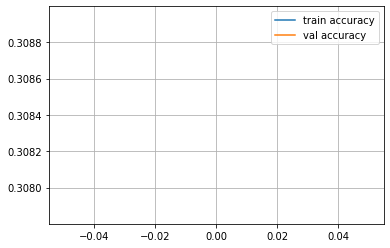

Epoch 1
Train accuracy: 0.2778716216216216
Val accuracy: 0.2779009608277901


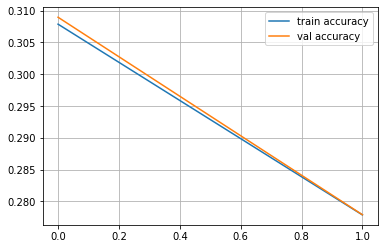

Epoch 2
Train accuracy: 0.28747888513513514
Val accuracy: 0.28775560482877555


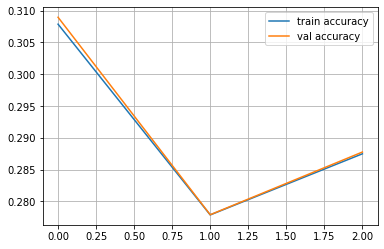

Epoch 3
Train accuracy: 0.3793285472972973
Val accuracy: 0.3771864991377186


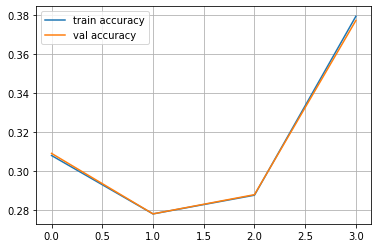

Epoch 4
Train accuracy: 0.4518581081081081
Val accuracy: 0.4469081054446908


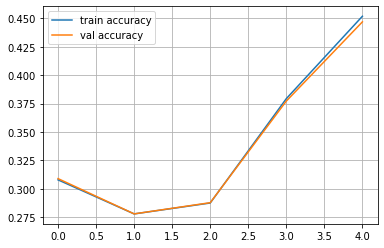

Epoch 5
Train accuracy: 0.48057432432432434
Val accuracy: 0.4737620103473762


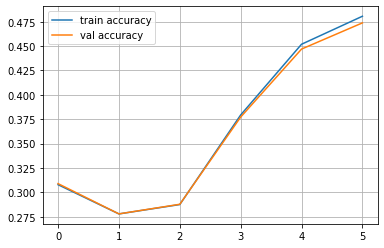

Epoch 6
Train accuracy: 0.4990498310810811
Val accuracy: 0.48805124414880513


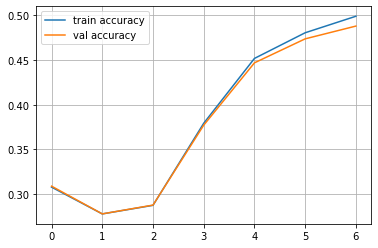

Epoch 7
Train accuracy: 0.5121410472972973
Val accuracy: 0.5023404779502341


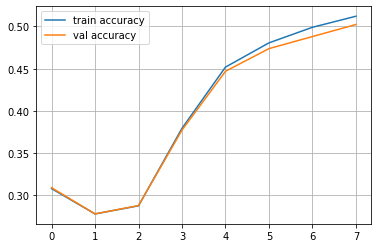

Epoch 8
Train accuracy: 0.5238597972972973
Val accuracy: 0.510470559251047


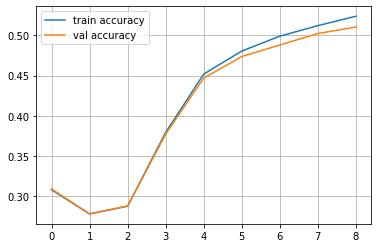

Epoch 9
Train accuracy: 0.5317778716216216
Val accuracy: 0.5188470066518847


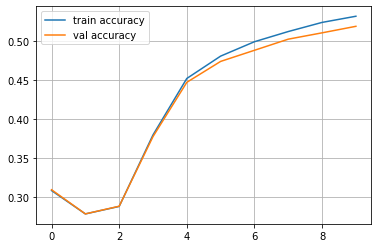

Epoch 10
Train accuracy: 0.5391680743243243
Val accuracy: 0.5252525252525253


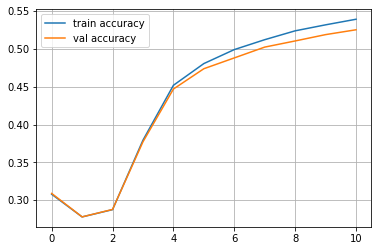

Epoch 11
Train accuracy: 0.5427576013513513
Val accuracy: 0.5267307218526731


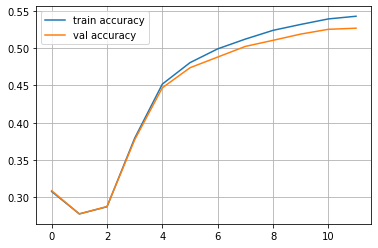

Epoch 12
Train accuracy: 0.5460304054054054
Val accuracy: 0.5294407489529441


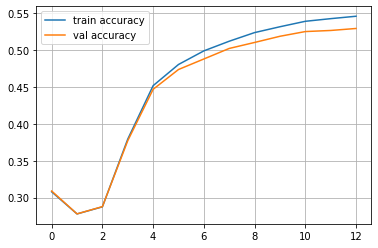

Epoch 13
Train accuracy: 0.5462415540540541
Val accuracy: 0.5296871150529687


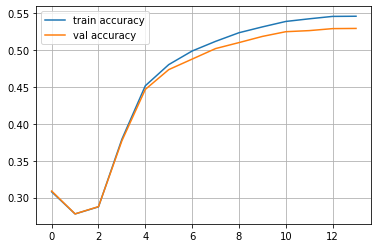

Epoch 14
Train accuracy: 0.5474028716216216
Val accuracy: 0.532150776053215


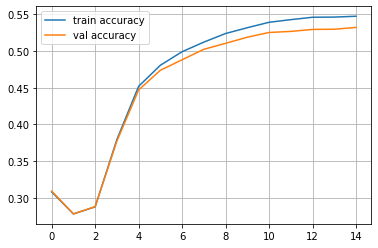

Epoch 15
Train accuracy: 0.5488809121621622
Val accuracy: 0.5341217048534121


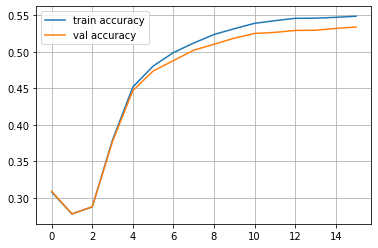

Epoch 16
Train accuracy: 0.5494087837837838
Val accuracy: 0.5328898743532889


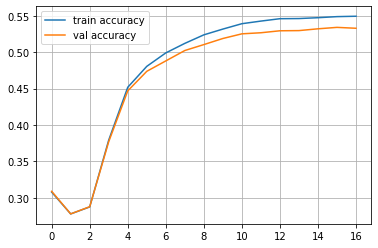

Epoch 17
Train accuracy: 0.5502533783783784
Val accuracy: 0.534860803153486


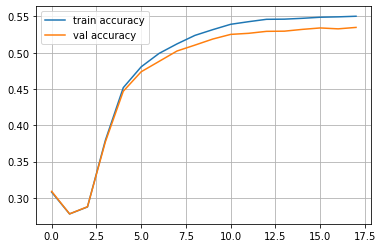

Epoch 18
Train accuracy: 0.5489864864864865
Val accuracy: 0.5351071692535108


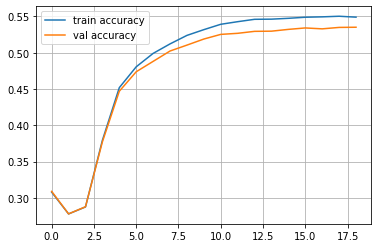

Epoch 19
Train accuracy: 0.5484586148648649
Val accuracy: 0.5353535353535354


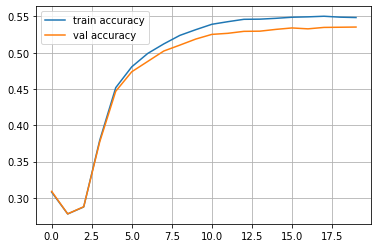

Epoch 20
Train accuracy: 0.5491976351351351
Val accuracy: 0.534860803153486


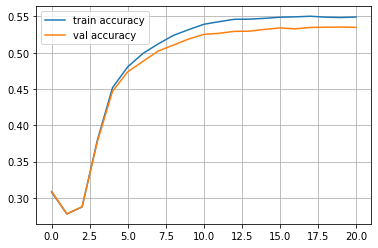

Epoch 21
Train accuracy: 0.5497255067567568
Val accuracy: 0.53559990145356


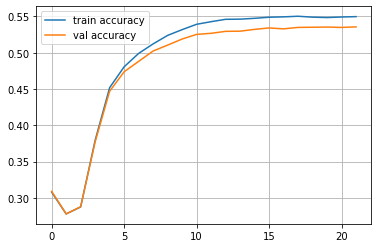

Epoch 22
Train accuracy: 0.5494087837837838
Val accuracy: 0.5365853658536586


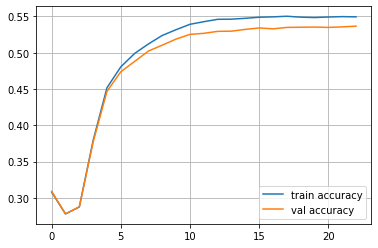

Epoch 23
Train accuracy: 0.5488809121621622
Val accuracy: 0.5368317319536832


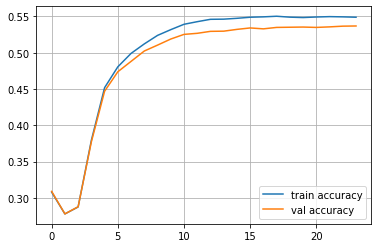

Epoch 24
Train accuracy: 0.5487753378378378
Val accuracy: 0.53559990145356


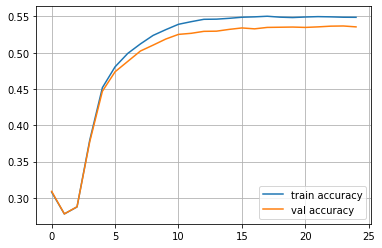

precision: 0.6041064640245448
recall: 0.5424699014343924
f1: 0.487315800701486
accuracy: 0.53559990145356
Confusion matrix: 
[[ 715   87  542]
 [ 245  197  950]
 [  35   26 1262]]


In [120]:
from IPython.display import clear_output
import numpy as np

network = MLP([10, 15, 20, 3], len(inputs))

train_log = []
val_log = []

for epoch in range(25):
    network.fit(x_train, y_train)   
    train_log.append(np.mean(network.predict(x_train) == y_train))
    val_log.append(np.mean(network.predict(x_test) == y_test))
    #clear_output()
    print("Epoch", epoch)
    print("Train accuracy:", train_log[-1])
    print("Val accuracy:", val_log[-1])  
    plt.plot(train_log,label = 'train accuracy')
    plt.plot(val_log,label = 'val accuracy')
    plt.legend(loc = 'best')
    plt.grid()
    plt.show()

y_pred = network.predict(x_test)

eval = Evaluate(y_test, y_pred)
eval.get_evaluation_report()

## Έτοιμο Multi-Layer Perceptron 

Όπως και με τις τεχνικές των παραπάνω ερωτημάτων έτσι και εδώ υπάρχει έτοιμη η παραπάνω κλάση σε διάφορες βιβλιοθήκες. Έτσι στο δεύτερο μέρος του ερωτήματος αυτού θα κατασκευάσετε το ίδιο MLP χρησιμοποιώντας όμως την έτοιμη κλάση [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)  της βιβλιοθήκης scikit-learn. Παρακάτω παρουσιάζεται ένα παράδειγμα χρήσης της κλάσης αυτής. 

In [121]:
from sklearn.neural_network import MLPClassifier

epochs = 25
mlp = MLPClassifier(hidden_layer_sizes=(10, 15, 20), max_iter = epochs)

mlp.fit(x_train,y_train)

y_pred = mlp.predict(x_test)
eval = Evaluate(y_test, y_pred)
eval.get_evaluation_report()

precision: 0.739233592650255
recall: 0.7255076519752217
f1: 0.7253363441808601
accuracy: 0.7262872628726287
Confusion matrix: 
[[ 822  319  203]
 [ 147 1122  123]
 [  50  269 1004]]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


## Σύγκριση υλοποιήσεων 

  

* Στα παρακάτω κελιά πειραματιστείτε με τις δύο υλοποιήσεις (τη δική σας και την έτοιμη).
* Συγκρίνετε τα αποτελέσματά σας τόσο ως προς τους χρόνους εκτέλεσης αλλά και ως προς τα αποτελέσματα.
* Η διαφορά των αποτελεσμάτων προκύπτει από το ότι στην έτοιμη κλάση έχουν γίνει αρκετές βελτιστοποιήσεις στην λειτουργία, στον τρόπο εκπαίδευσης κ.α. με αποτέλεσμα να προκύπτουν καλύτερα αποτέλεσματα.
* Παρόλα αυτά στην δική μας κλάση έχουμε καλύτερο έλεγχο και έχουμε την δυνατότητα να σχεδιάσουμε πιο σύνθετες αρχιτεκτονικές καθώς να αλλάξουμε τις τιμές παραμέτρων που στην έτοιμη κλάση μπορεί να μην μας δίνεται η δυνατότητα. 


* Ορίζω τις συναρτήσεις `create_train_test_MLP` και `scikit_train_test_MLP` για να επαναχρησιμοποιώ τον κώδικα στις διάφορες δοκιμές:

In [125]:
from IPython.display import clear_output
import numpy as np

def create_train_test_MLP(layers, inputs, epochs, logging=False):
  global x_train, y_train, x_test, y_test
  network = MLP(layers, len(inputs))
  train_log = []
  val_log = []
  for epoch in range(epochs):
    network.fit(x_train, y_train)   
    train_log.append(np.mean(network.predict(x_train) == y_train))
    val_log.append(np.mean(network.predict(x_test) == y_test))
    #clear_output()
    if logging:
      print("Epoch", epoch)
      print("Train accuracy:", train_log[-1])
      print("Val accuracy:", val_log[-1])  
  plt.figure()
  plt.plot(train_log,label = 'train accuracy')
  plt.plot(val_log,label = 'val accuracy')
  plt.legend(loc = 'best')
  plt.grid()
  plt.show()
  y_pred = network.predict(x_test)
  eval = Evaluate(y_test, y_pred)
  eval.get_evaluation_report()
  return eval.get_metrics()

def scikit_train_test_MLP(layers, inputs, epochs):
  global x_train, y_train, x_test, y_test
  mlp = MLPClassifier(hidden_layer_sizes=layers, max_iter = epochs)
  mlp.fit(x_train,y_train)
  y_pred = mlp.predict(x_test)
  eval = Evaluate(y_test, y_pred)
  eval.get_evaluation_report()
  return eval.get_metrics()

### Δοκιμάζω για 25 epochs:

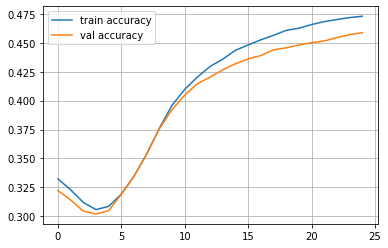

precision: 0.5100093668181157
recall: 0.46670519261344384
f1: 0.3762769091237592
accuracy: 0.45873367824587336
Confusion matrix: 
[[ 573    8  763]
 [ 105   14 1273]
 [  28   20 1275]]
CPU times: user 1.3 s, sys: 1.09 s, total: 2.39 s
Wall time: 1.91 s


In [129]:
%%time
my_metrics_small_25 = create_train_test_MLP(layers=[10, 15, 20, 3], inputs=inputs, epochs=25)

In [130]:
%%time
scikit_metrics_small_25 = scikit_train_test_MLP(layers=(10, 15, 20), inputs=inputs, epochs=25)

precision: 0.7461028174110936
recall: 0.7350781867664052
f1: 0.7355016979808902
accuracy: 0.7356491746735649
Confusion matrix: 
[[ 861  307  176]
 [ 149 1110  133]
 [  59  249 1015]]
CPU times: user 1.73 s, sys: 46.7 ms, total: 1.78 s
Wall time: 1.85 s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


### Δοκιμάζω να αυξήσω τον αριθμό των epochs στις 100:

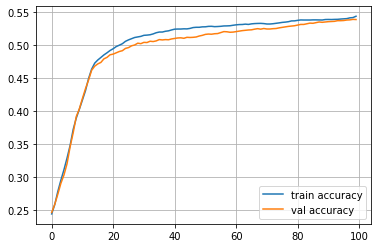

precision: 0.5329047591014174
recall: 0.5460519456824876
f1: 0.44835276918024974
accuracy: 0.538309928553831
Confusion matrix: 
[[1004   29  311]
 [ 637   41  714]
 [ 174    9 1140]]
CPU times: user 4.27 s, sys: 3.92 s, total: 8.19 s
Wall time: 6.54 s


In [132]:
%%time
my_metrics_small_100 = create_train_test_MLP(layers=[10, 15, 20, 3], inputs=inputs, epochs=100)

In [133]:
%%time
scikit_metrics_small_100 = scikit_train_test_MLP(layers=(10, 15, 20), inputs=inputs, epochs=100)

precision: 0.7456736008643516
recall: 0.738483619820853
f1: 0.7400707359412375
accuracy: 0.7388519339738852
Confusion matrix: 
[[ 939  289  116]
 [ 191 1075  126]
 [ 101  237  985]]
CPU times: user 6.79 s, sys: 39.2 ms, total: 6.83 s
Wall time: 8.67 s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


### Δοκιμάζω να δεκαπλασιάσω τον αριθμό των νευρώνων στα layers, κρατώντας τον αριθμό των epochs στις 25:

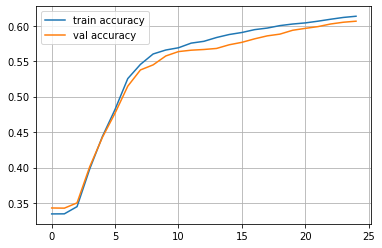

precision: 0.6639651661038797
recall: 0.6089959850479144
f1: 0.6008874510827422
accuracy: 0.6063069721606307
Confusion matrix: 
[[ 633  233  478]
 [  99  686  607]
 [  16  165 1142]]
CPU times: user 13.1 s, sys: 5.4 s, total: 18.5 s
Wall time: 14.2 s


In [134]:
%%time
my_metrics_large_25 = create_train_test_MLP(layers=[100, 150, 200, 3], inputs=inputs, epochs=25)

In [136]:
%%time
scikit_metrics_large_25 = scikit_train_test_MLP(layers=(100, 150, 200), inputs=inputs, epochs=25)

precision: 0.7469738314855796
recall: 0.7418274222204846
f1: 0.7412290980171546
accuracy: 0.7418083271741809
Confusion matrix: 
[[ 883  252  209]
 [ 165 1067  160]
 [  58  204 1061]]
CPU times: user 12 s, sys: 5.21 s, total: 17.2 s
Wall time: 8.82 s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


### Συμπεράσματα

* Στο διάγραμμα που ακολουθεί:
  * ως προς τον αριθμό των νευρώνων, συμβολίζω με:
    * sm τα δίκτυα με νευρώνες [10, 15, 20]
    * lg τα δίκτυα με νευρώνες [100, 150, 200]
  * στο τέλος κάθε ονόματος έχω τον αριθμό των epochs
    * { 25, 100 }
  * αν ο classifier είναι από το scikit, βάζω το πρόθεμα 'sci'



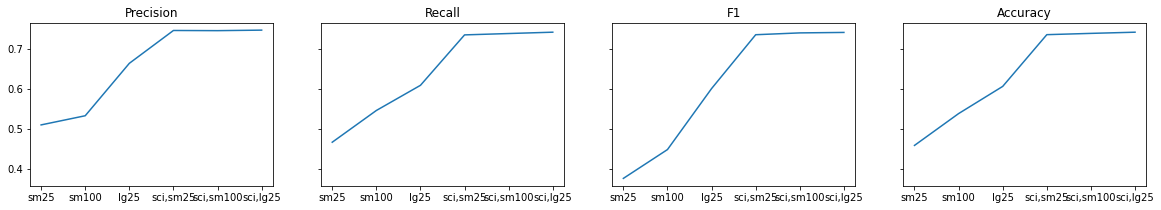

In [143]:
names = ['sm25', 'sm100', 'lg25', 'sci,sm25', 'sci,sm100', 'sci,lg25']
values = [
  my_metrics_small_25,
  my_metrics_small_100,
  my_metrics_large_25,
  scikit_metrics_small_25,
  scikit_metrics_small_100,
  scikit_metrics_large_25,
]
plot_metrics(names, values)


* Για το MLP που χτίσαμε εμείς:
  * Με τον τετραπλασιασμό των epochs κι ενώ ο αριθμός των νευρώνων μένει σταθερός:
    * παρατηρώ ότι οι μετρικές απόδοσης βελτιώνονται, όπως ήταν αναμενόμενο και από την μορφή της γραφικής παράστασης
    * ο χρόνος που χρειάστηκε περίπου τετραπλασιάστηκε (φαίνεται να τηρείται μία σχέση αναλογίας με τον αριθμό των epochs)
  * Με τον δεκαπλασιασμό του αριθμού των νευρώνων:
    * οι μετρικές απόδοσης βελτιώνονται ακόμα περισσότερο από την προηγούμενη περίπτωση, όπου αυξήσαμε απλά τον αριθμό των epochs
    * ο χρόνος δεκαπλασιάστηκε (πάλι παρατηρείται μία αναλογία)
* Για το MLP του scikit-learn:
  * καταλήγουμε σε όμοια συμπεράσματα ως προς τον χρόνο
  * οι μετρικές απόδοσης βελτιώνονται ελάχιστα σε σχέση από ότι στο δικό μας MLP (ξεκινάνε από υψηλότερες τιμές της τάξης του 72-75% και φτάνουν όλες στο 75%)


# Αξιολόγηση- Συμπεράσματα 

  

Τέλος στο σημείο αυτό καλείστε να αξιολογήσετε τις διάφορες τεχνικές ταξινόμησης (KNN, Naive Bayes, MLP), τα αποτελέσματά τους, τους χρόνους εκτέλεσης, και να παραθέσετε παρατηρήσεις καθώς και οτιδήποτε σας φάνηκε ενδιαφέρον ή ιδιαίτερο. 



Απάντηση/Σχολιασμός:

* Για τον KNN classifier:
  * Οι μετρικές των επιδόσεων είναι ικανοποιητικές (ξεκινάνε από 60% και με αύξηση του k φτάνουν στο 70%).
  * Οι χρόνοι εκπαίδευσης είναι μεγάλοι συγκριτικά με τις υπόλοιπες τεχνικές.
  * Μπορέσαμε σχετικά εύκολα να χτίσουμε τον δικό μας KNN και να πετύχουμε υψηλές μετρικές, αρκετά κοντικές με τον αντίστοιχο classifier της scikit-learn.

* Για τον Naive Bayes:
  * Οι μετρικές που κατάφερα να πετύχω με τον classifier που έχτισα δεν ήταν καθόλου ικανοποιητικές, σε αντίθεση με τις μετρικές του έτοιμου Gaussian Naive Bayes της scikit-learn, που ήταν της τάξης του 70%.
  * Αυτό οφείλεται στην προσεγγιστική μετατροπή της εισόδου από συνεχή σε διακριτή και στο ότι για το συγκεκριμένο dataset, η κανονική κατανομή, που υποθέτει ο GNB, ίσως ταιριάζει καλύτερα.
  * Όσον αφορά τους χρόνους εκπαίδευσης και πρόβλεψης, ο Naive Bayes φάνηκε να είναι ο πιο γρήγορος classifier (τόσο ο δικός μου, όσο και ο έτοιμος).
  * Η κατασκευή του ήταν πιο δύσκολη από του KNN.

* Για το MLP:
  * Οι μετρικές που πετυχαίνουν οι classifiers αυτής της τεχνικής ήταν οι υψηλότερες.
  * Αποτελεί την πιο σύνθετη στην κατανόηση τεχνική.
  * Οι δικοί μου classifiers, με την αύξηση των epochs και του πλήθους των νευρώνων, πετυχαίνουν αρκετά ικανοποιητικές μετρικές, αλλά χρειάζονται όλο και μεγαλύτερο χρόνο εκπαίδευσης.
  * Ο classifier του scikit-learn, με μικρό αριθμό νευρώνων και epochs πετυχαίνει μετρικές μεγαλύτερες του 70% σε μέτριο χρονικά διάστημα σε σχέση με τους υπόλοιπους classifiers.


Αν έπρεπε να επιλέξω έναν classifier, θα επέλεγα είτε την έτοιμη υλοποίηση του GNB, αφού είναι με διαφορά το πιο γρήγορο μοντέλο και παρουσιάζει ικανοποιητικές μετρικές, είτε κάποια υλοποίηση του MLP (δικιά μου ή έτοιμη), αφού μπορεί να εφαρμοστεί σε πολλά προβλήματα, ενώ παρουσιάζει υψηλή επίδοση και στο συγκεκριμένο πρόβλημα.